#  Notebook 06 : Interprétabilité avec SHAP

**Projet 7 - Prêt à dépenser : Scoring Crédit**

## Objectifs

1. Charger le pipeline et les données de validation
2. Aligner les features avec le modèle
3. Initialiser SHAP TreeExplainer
4. Calculer les valeurs SHAP
5. Créer des visualisations globales :
   - Summary plot (beeswarm)
   - Bar plot de l'importance
   - Dependence plots
6. Créer des visualisations locales :
   - Waterfall plots pour des clients spécifiques
   - Force plots individuels
7. Analyser l'impact des features principales
8. Comparer des cas de crédit accordé vs refusé

---

## 1. Imports et Configuration

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path

# SHAP
import shap

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Pour les notebooks
shap.initjs()

print(" Imports réussis")
print(f"Version SHAP: {shap.__version__}")

 Imports réussis
Version SHAP: 0.43.0


## 2. Chargement du Pipeline et des Données

In [2]:
# Chemins
ARTIFACTS_DIR = Path('./artifacts')
FIGURES_DIR = Path('./figures')
FIGURES_DIR.mkdir(exist_ok=True)  # Créer le dossier s'il n'existe pas

PIPELINE_PATH = ARTIFACTS_DIR / 'meilleur_modele.joblib'
DATA_SPLIT_PATH = ARTIFACTS_DIR / 'data_split.joblib'
FEATURE_NAMES_PATH = ARTIFACTS_DIR / 'feature_names.joblib'

print("="*60)
print("CHARGEMENT DES DONNÉES")
print("="*60)

# Charger le pipeline
print("\nChargement du pipeline...")
pipeline = joblib.load(PIPELINE_PATH)
print(f" Pipeline chargé: {type(pipeline)}")

# Charger les données de validation (on utilisera X_valid comme données de test)
print("\nChargement des données...")
X_train, X_valid, y_train, y_valid = joblib.load(DATA_SPLIT_PATH)
print(f" X_valid shape: {X_valid.shape}")
print(f" y_valid shape: {y_valid.shape}")

# Charger les noms de features si disponibles
try:
    feature_names = joblib.load(FEATURE_NAMES_PATH)
    print(f"\n {len(feature_names)} noms de features chargés")
except FileNotFoundError:
    feature_names = list(X_valid.columns)
    print(f"\n feature_names.joblib non trouvé, utilisation des colonnes de X_valid")
    print(f" {len(feature_names)} features")

print("\n" + "="*60)
print("RÉSUMÉ")
print("="*60)
print(f"  - Échantillon de validation: {X_valid.shape[0]:,} clients")
print(f"  - Features: {X_valid.shape[1]}")
print(f"  - Taux de défaut: {y_valid.mean():.2%}")
print("="*60)

CHARGEMENT DES DONNÉES

Chargement du pipeline...
 Pipeline chargé: <class 'lightgbm.sklearn.LGBMClassifier'>

Chargement des données...
 X_valid shape: (61502, 794)
 y_valid shape: (61502,)

 794 noms de features chargés

RÉSUMÉ
  - Échantillon de validation: 61,502 clients
  - Features: 794
  - Taux de défaut: 8.07%


In [3]:
# ============================================================================
# FONCTION REQUISE POUR LE CHARGEMENT DU PREPROCESSEUR
# ============================================================================
#
# Le preprocesseur contient un FunctionTransformer avec cette fonction.
# Elle DOIT être définie AVANT de charger le preprocesseur avec joblib.load()
#

def convert_to_string(X):
    """
    Convertit toutes les valeurs en string pour OneHotEncoder.
    
    Cette fonction est utilisée dans le pipeline de preprocessing
    pour garantir que le OneHotEncoder reçoit des strings.
    """
    import pandas as pd
    import numpy as np
    
    if isinstance(X, pd.DataFrame):
        return X.astype(str)
    elif isinstance(X, pd.Series):
        return X.astype(str)
    elif isinstance(X, np.ndarray):
        return np.array(X).astype(str)
    else:
        return X

print(" Fonction convert_to_string définie")
print("   Cette fonction est requise pour charger le preprocesseur")


 Fonction convert_to_string définie
   Cette fonction est requise pour charger le preprocesseur


In [4]:
print("="*60)
print("TRANSFORMATION DES DONNÉES POUR SHAP")
print("="*60)

# Charger le preprocesseur
PREPROCESSEUR_PATH = ARTIFACTS_DIR / 'preprocesseur.joblib'
print("\nChargement du preprocesseur...")
preprocesseur = joblib.load(PREPROCESSEUR_PATH)
print(f" Preprocesseur chargé: {type(preprocesseur)}")

# Transformer les données de validation
print("\nTransformation des données...")
X_valid_transformed = preprocesseur.transform(X_valid)
print(f" Shape après transformation: {X_valid_transformed.shape}")

# Récupérer les noms de features transformées
try:
    feature_names_transformed = preprocesseur.get_feature_names_out()
    print(f" Noms récupérés via get_feature_names_out()")
except AttributeError:
    # Fallback : utiliser les noms du modèle
    try:
        feature_names_transformed = pipeline.feature_name_
        print(f" Noms récupérés via pipeline.feature_name_")
    except:
        feature_names_transformed = [f"feature_{i}" for i in range(X_valid_transformed.shape[1])]
        print(f" Utilisation de noms génériques")

# Convertir en DataFrame
X_valid = pd.DataFrame(
    X_valid_transformed,
    columns=feature_names_transformed,
    index=X_valid.index
)

print(f"\n DataFrame créé avec {len(X_valid.columns)} colonnes")
print(f"   Exemples de colonnes: {list(X_valid.columns[:5])}")


TRANSFORMATION DES DONNÉES POUR SHAP

Chargement du preprocesseur...
 Preprocesseur chargé: <class 'sklearn.compose._column_transformer.ColumnTransformer'>

Transformation des données...
 Shape après transformation: (61502, 804)
 Noms récupérés via pipeline.feature_name_

 DataFrame créé avec 804 colonnes
   Exemples de colonnes: ['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4']


In [5]:
print("="*60)
print("CRÉATION DU MAPPING DES FEATURES")
print("="*60)

# Charger les noms originaux
try:
    feature_names_original = joblib.load(FEATURE_NAMES_PATH)
    print(f" {len(feature_names_original)} noms de features originaux chargés")
except FileNotFoundError:
    print(" feature_names.joblib non trouvé")
    # Utiliser les colonnes de X_valid comme fallback
    feature_names_original = list(X_valid.columns)

# Créer le mapping transformé -> original
feature_mapping = {}

# Si les longueurs correspondent
if len(feature_names_transformed) == len(feature_names_original):
    feature_mapping = dict(zip(feature_names_transformed, feature_names_original))
    print(f" Mapping créé: {len(feature_mapping)} correspondances")
else:
    print(f" Tailles différentes: {len(feature_names_transformed)} vs {len(feature_names_original)}")
    # Utiliser les noms transformés comme fallback
    feature_mapping = {f: f for f in feature_names_transformed}

# Afficher quelques exemples
print("\nExemples de mapping:")
for i, (transformed, original) in enumerate(feature_mapping.items()):
    if i < 10:
        print(f"  {transformed[:30]:30s} → {original[:50]}")
    else:
        print(f"  ... et {len(feature_mapping) - 10} autres")
        break

# Sauvegarder le mapping
mapping_path = ARTIFACTS_DIR / 'feature_mapping.joblib'
joblib.dump(feature_mapping, mapping_path)
print(f"\n Mapping sauvegardé: {mapping_path}")


CRÉATION DU MAPPING DES FEATURES
 794 noms de features originaux chargés
 Tailles différentes: 804 vs 794

Exemples de mapping:
  Column_0                       → Column_0
  Column_1                       → Column_1
  Column_2                       → Column_2
  Column_3                       → Column_3
  Column_4                       → Column_4
  Column_5                       → Column_5
  Column_6                       → Column_6
  Column_7                       → Column_7
  Column_8                       → Column_8
  Column_9                       → Column_9
  ... et 794 autres

 Mapping sauvegardé: artifacts\feature_mapping.joblib


## 3. Alignement des Features avec le Modèle

Important : Il faut s'assurer que les données ont le même nombre de colonnes que lors de l'entraînement.

In [6]:
print("="*60)
print("ALIGNEMENT DES FEATURES")
print("="*60)

# Récupérer les features attendues par le modèle
try:
    expected_features = pipeline.feature_name_
    print("✓ Features récupérées via feature_name_")
except:
    try:
        expected_features = pipeline.booster_.feature_name()
        print("✓ Features récupérées via booster_.feature_name()")
    except:
        try:
            expected_features = pipeline._Booster.feature_name()
            print("✓ Features récupérées via _Booster.feature_name()")
        except:
            # Si impossible de récupérer, utiliser les feature_names chargés
            expected_features = feature_names
            print(" Utilisation des feature_names chargés")

print(f"\nFeatures attendues par le modèle: {len(expected_features)}")
print(f"Features dans X_valid: {len(X_valid.columns)}")

# Identifier les différences
current_cols = set(X_valid.columns)
expected_cols = set(expected_features)

missing_cols = list(expected_cols - current_cols)
extra_cols = list(current_cols - expected_cols)

if len(missing_cols) > 0:
    print(f"\n Colonnes manquantes: {len(missing_cols)}")
    if len(missing_cols) <= 10:
        print(f"   {missing_cols}")
    else:
        print(f"   {missing_cols[:5]}... (+{len(missing_cols)-5} autres)")
    
    # Ajouter les colonnes manquantes
    print("\nAjout des colonnes manquantes...")
    missing_df = pd.DataFrame(0, index=X_valid.index, columns=missing_cols)
    X_valid = pd.concat([X_valid, missing_df], axis=1)
    print("✓ Colonnes ajoutées")

if len(extra_cols) > 0:
    print(f"\n Colonnes en trop: {len(extra_cols)}")
    if len(extra_cols) <= 10:
        print(f"   {extra_cols}")
    else:
        print(f"   {extra_cols[:5]}... (+{len(extra_cols)-5} autres)")
    
    # Supprimer les colonnes en trop
    print("\nSuppression des colonnes en trop...")
    X_valid = X_valid.drop(columns=extra_cols)
    print("✓ Colonnes supprimées")

# Réordonner les colonnes
print("\nRéordonnancement des colonnes...")
X_valid = X_valid[expected_features]
print("✓ Colonnes réordonnées")

print(f"\n Shape finale: {X_valid.shape}")

ALIGNEMENT DES FEATURES
✓ Features récupérées via feature_name_

Features attendues par le modèle: 804
Features dans X_valid: 804

Réordonnancement des colonnes...
✓ Colonnes réordonnées

 Shape finale: (61502, 804)


## 4. Conversion des Types de Données

In [7]:
print("="*60)
print("CONVERSION DES TYPES")
print("="*60)

# Identifier les colonnes object
object_cols = X_valid.select_dtypes(include=['object']).columns.tolist()
print(f"\nColonnes 'object' à convertir: {len(object_cols)}")

# Convertir les colonnes object en numérique
if len(object_cols) > 0:
    print("Conversion en cours...")
    for col in object_cols:
        X_valid[col] = pd.to_numeric(X_valid[col], errors='coerce')
    print("✓ Conversion terminée")

# Gérer les valeurs manquantes
nan_count = X_valid.isna().sum().sum()
if nan_count > 0:
    print(f"\nValeurs NaN détectées: {nan_count:,}")
    X_valid = X_valid.fillna(0)
    print("✓ NaN remplacés par 0")

print(f"\n Données prêtes pour SHAP")
print(f"   Shape: {X_valid.shape}")
print(f"   NaN restants: {X_valid.isna().sum().sum()}")

CONVERSION DES TYPES

Colonnes 'object' à convertir: 0

Valeurs NaN détectées: 11,964,490
✓ NaN remplacés par 0

 Données prêtes pour SHAP
   Shape: (61502, 804)
   NaN restants: 0


## 5. Préparation de l'Échantillon pour SHAP

Pour des raisons de performance, on utilise un échantillon des données.

In [8]:
print("="*60)
print("PRÉPARATION DE L'ÉCHANTILLON SHAP")
print("="*60)

# Définir la taille de l'échantillon
# Pour SHAP, on recommande 100-500 observations pour un bon compromis vitesse/qualité
sample_size = min(200, len(X_valid))

# Échantillonnage stratifié pour garder la distribution des classes
from sklearn.model_selection import train_test_split

if len(X_valid) > sample_size:
    X_sample, _, y_sample, _ = train_test_split(
        X_valid, y_valid, 
        train_size=sample_size,
        stratify=y_valid,
        random_state=42
    )
    print(f"✓ Échantillon stratifié créé: {sample_size} observations")
else:
    X_sample = X_valid
    y_sample = y_valid
    print(f"✓ Utilisation de toutes les données: {len(X_sample)} observations")

print(f"\nDistribution dans l'échantillon:")
print(f"  Classe 0 (bon): {(y_sample == 0).sum()} ({(y_sample == 0).mean():.1%})")
print(f"  Classe 1 (défaut): {(y_sample == 1).sum()} ({(y_sample == 1).mean():.1%})")

# Générer les prédictions pour l'échantillon
print("\nGénération des prédictions...")
y_pred_proba = pipeline.predict_proba(X_sample)[:, 1]
print(f"✓ Prédictions générées")
print(f"   Probabilité moyenne: {y_pred_proba.mean():.3f}")
print(f"   Min: {y_pred_proba.min():.3f}, Max: {y_pred_proba.max():.3f}")

PRÉPARATION DE L'ÉCHANTILLON SHAP
✓ Échantillon stratifié créé: 200 observations

Distribution dans l'échantillon:
  Classe 0 (bon): 184 (92.0%)
  Classe 1 (défaut): 16 (8.0%)

Génération des prédictions...
✓ Prédictions générées
   Probabilité moyenne: 0.295
   Min: 0.009, Max: 0.942


## 6. Initialisation de SHAP TreeExplainer

Pour les modèles LightGBM, on utilise **TreeExplainer** qui est optimisé et rapide.

In [9]:
print("="*60)
print("INITIALISATION DE SHAP")
print("="*60)

# Initialiser l'explainer avec le modèle
print("\nInitialisation du SHAP TreeExplainer...")
explainer = shap.TreeExplainer(pipeline)
print(f" Explainer initialisé pour {type(pipeline).__name__}")

# Calculer les valeurs SHAP
print(f"\nCalcul des valeurs SHAP pour {len(X_sample)} observations...")
print("⏳ Cela peut prendre quelques secondes...")

shap_values = explainer.shap_values(X_sample)

# Pour classification binaire, shap_values peut être:
# - Une liste [class_0, class_1] pour certains modèles
# - Un array unique pour d'autres
if isinstance(shap_values, list):
    # Prendre les valeurs pour la classe positive (défaut = 1)
    shap_values_class1 = shap_values[1]
    print(" Valeurs SHAP calculées (liste - pris classe 1)")
else:
    shap_values_class1 = shap_values
    print(" Valeurs SHAP calculées (array unique)")

print(f"\nShape des valeurs SHAP: {shap_values_class1.shape}")
print(f"Expected value (base): {explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1]:.4f}")

# Stocker la base value
if isinstance(explainer.expected_value, list):
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

print(f"\n La base value ({base_value:.4f}) représente la prédiction moyenne du modèle")

INITIALISATION DE SHAP

Initialisation du SHAP TreeExplainer...
 Explainer initialisé pour LGBMClassifier

Calcul des valeurs SHAP pour 200 observations...
⏳ Cela peut prendre quelques secondes...
 Valeurs SHAP calculées (liste - pris classe 1)

Shape des valeurs SHAP: (200, 804)
Expected value (base): -2.9180

 La base value (-2.9180) représente la prédiction moyenne du modèle


## 7. Visualisations Globales

### 7.1 Summary Plot (Beeswarm)

Ce graphique montre :
- **Axe vertical** : Features ordonnées par importance
- **Axe horizontal** : Impact sur la prédiction
- **Couleur** : Valeur de la feature (rouge = élevé, bleu = faible)

SUMMARY PLOT (BEESWARM)


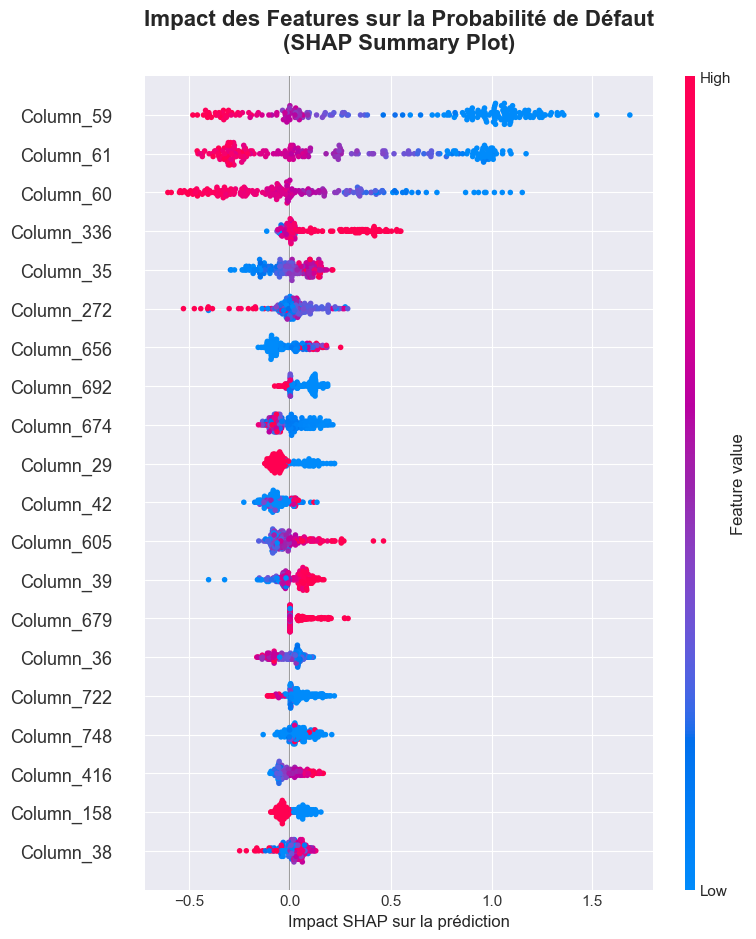


 Summary plot créé et sauvegardé
   Fichier: figures\shap_summary_beeswarm.png


In [10]:
print("="*60)
print("SUMMARY PLOT (BEESWARM)")
print("="*60)

plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values_class1,
    X_sample,
    max_display=20,
    show=False
)
plt.title("Impact des Features sur la Probabilité de Défaut\n(SHAP Summary Plot)", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Impact SHAP sur la prédiction", fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Summary plot créé et sauvegardé")
print(f"   Fichier: {FIGURES_DIR / 'shap_summary_beeswarm.png'}")

### 7.2 Bar Plot (Importance Moyenne Absolue)

Ce graphique montre l'importance moyenne absolue de chaque feature.

BAR PLOT (IMPORTANCE)


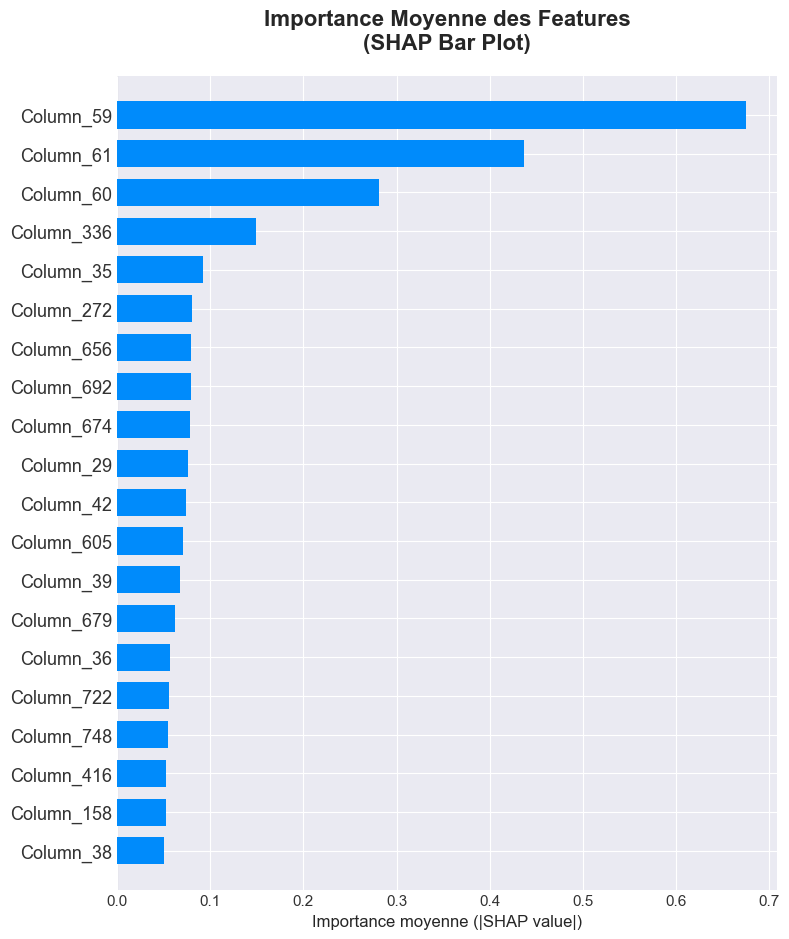


 Bar plot créé et sauvegardé
   Fichier: figures\shap_bar_plot.png


In [11]:
print("="*60)
print("BAR PLOT (IMPORTANCE)")
print("="*60)

plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values_class1,
    X_sample,
    max_display=20,
    plot_type='bar',
    show=False
)
plt.title("Importance Moyenne des Features\n(SHAP Bar Plot)", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Importance moyenne (|SHAP value|)", fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Bar plot créé et sauvegardé")
print(f"   Fichier: {FIGURES_DIR / 'shap_bar_plot.png'}")

### 7.3 Top Features

Calculons les features les plus importantes selon SHAP.

In [12]:
print("="*60)
print("IMPORTANCE DES FEATURES")
print("="*60)

# Calculer l'importance moyenne absolue
feature_importance_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 15 Features les plus importantes (SHAP):")
print("="*60)
for idx, row in feature_importance_shap.head(15).iterrows():
    print(f"{row['feature']:50s} : {row['importance']:.6f}")

# Sauvegarder
feature_importance_shap.to_csv(ARTIFACTS_DIR / 'shap_feature_importance.csv', index=False)
print(f"\n Importance SHAP sauvegardée")
print(f"   Fichier: {ARTIFACTS_DIR / 'shap_feature_importance.csv'}")

IMPORTANCE DES FEATURES

Top 15 Features les plus importantes (SHAP):
Column_59                                          : 0.674996
Column_61                                          : 0.436647
Column_60                                          : 0.281444
Column_336                                         : 0.149231
Column_35                                          : 0.092074
Column_272                                         : 0.080000
Column_656                                         : 0.079670
Column_692                                         : 0.079249
Column_674                                         : 0.077925
Column_29                                          : 0.075925
Column_42                                          : 0.073882
Column_605                                         : 0.070763
Column_39                                          : 0.067306
Column_679                                         : 0.062403
Column_36                                          : 0.057218


### 7.4 Dependence Plots

Ces graphiques montrent comment la valeur d'une feature influence la prédiction.

DEPENDENCE PLOTS

Création des dependence plots pour les 6 features les plus importantes...


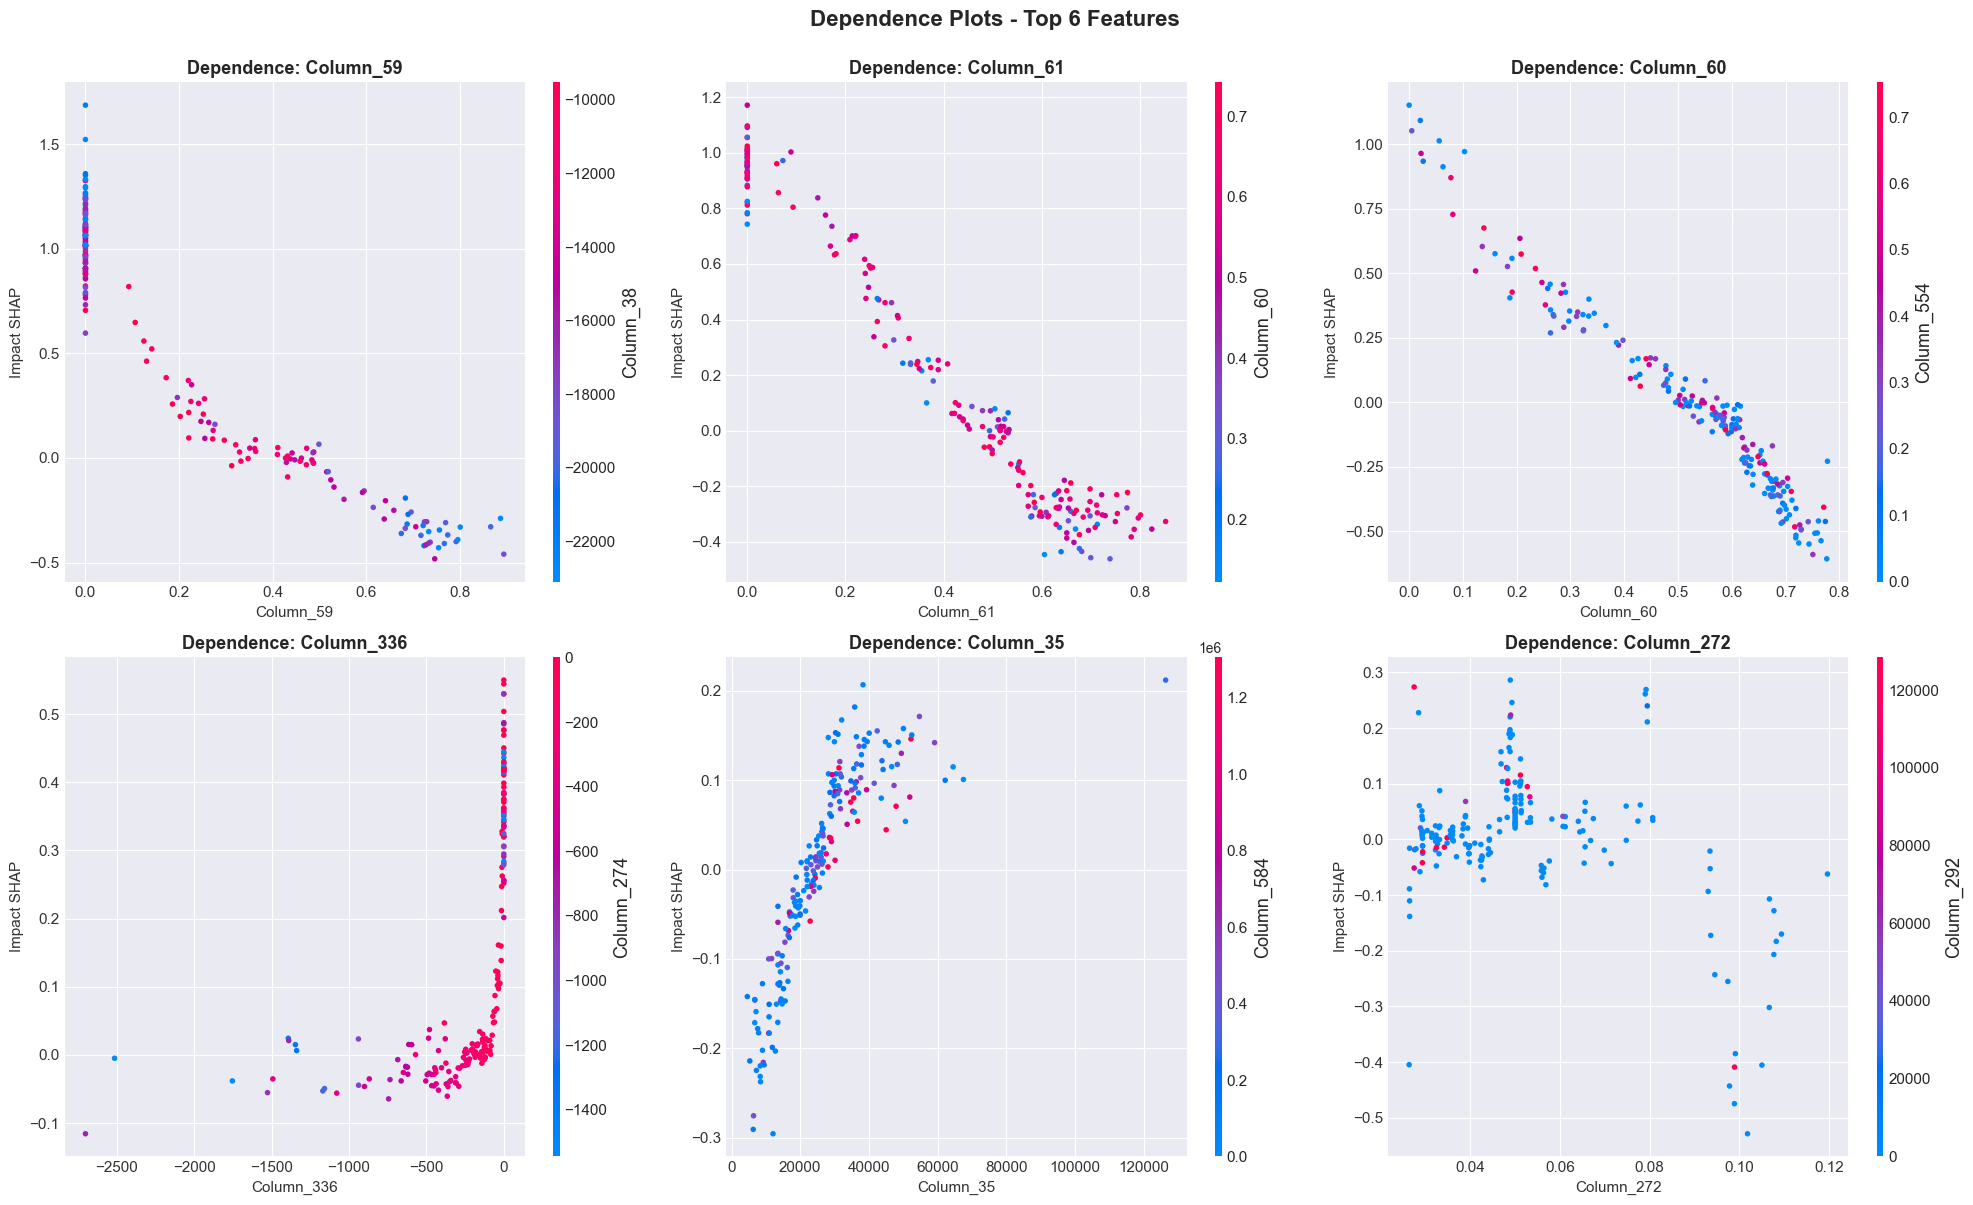


 Dependence plots créés et sauvegardés
   Fichier: figures\shap_dependence_plots.png


In [13]:
print("="*60)
print("DEPENDENCE PLOTS")
print("="*60)

# Prendre les 6 features les plus importantes
top_features = feature_importance_shap.head(6)['feature'].tolist()

print(f"\nCréation des dependence plots pour les {len(top_features)} features les plus importantes...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, feature_name in enumerate(top_features):
    # Trouver l'index de la feature
    feature_idx = list(X_sample.columns).index(feature_name)
    
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature_idx,
        shap_values_class1,
        X_sample,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f"Dependence: {feature_name}", fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(feature_name, fontsize=11)
    axes[idx].set_ylabel("Impact SHAP", fontsize=11)

plt.suptitle("Dependence Plots - Top 6 Features", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Dependence plots créés et sauvegardés")
print(f"   Fichier: {FIGURES_DIR / 'shap_dependence_plots.png'}")

## 8. Visualisations Locales (Clients Individuels)

### 8.1 Sélection d'Exemples Intéressants

In [14]:
print("="*60)
print("SÉLECTION D'EXEMPLES")
print("="*60)

# Trouver des exemples intéressants:
# 1. Client avec très faible risque (crédit accordé)
idx_low_risk = np.argmin(y_pred_proba)

# 2. Client avec risque élevé (crédit refusé)
idx_high_risk = np.argmax(y_pred_proba)

# 3. Client proche du seuil de décision
# Charger le seuil optimal si disponible
try:
    params = joblib.load(ARTIFACTS_DIR / 'parametres_decision.joblib')
    seuil = params['seuil_optimal']
    print(f"✓ Seuil optimal chargé: {seuil:.4f}")
except:
    seuil = 0.5
    print(f" Utilisation du seuil par défaut: {seuil}")

idx_borderline = np.argmin(np.abs(y_pred_proba - seuil))

# Afficher les exemples sélectionnés
print("\nExemples sélectionnés:")
print("="*60)

exemples = [
    (" FAIBLE RISQUE", idx_low_risk),
    (" BORDERLINE", idx_borderline),
    (" RISQUE ÉLEVÉ", idx_high_risk)
]

for nom, idx in exemples:
    proba = y_pred_proba[idx]
    vrai_label = "Défaut" if y_sample.iloc[idx] == 1 else "Bon"
    decision = "REFUSÉ" if proba >= seuil else "ACCEPTÉ"
    
    print(f"\n{nom} (Index: {idx})")
    print(f"  Probabilité de défaut: {proba:.4f}")
    print(f"  Vraie classe: {vrai_label}")
    print(f"  Décision: {decision}")

SÉLECTION D'EXEMPLES
 Utilisation du seuil par défaut: 0.5

Exemples sélectionnés:

 FAIBLE RISQUE (Index: 187)
  Probabilité de défaut: 0.0090
  Vraie classe: Bon
  Décision: ACCEPTÉ

 BORDERLINE (Index: 41)
  Probabilité de défaut: 0.4954
  Vraie classe: Bon
  Décision: ACCEPTÉ

 RISQUE ÉLEVÉ (Index: 37)
  Probabilité de défaut: 0.9416
  Vraie classe: Bon
  Décision: REFUSÉ


### 8.2 Waterfall Plots

Les waterfall plots montrent comment chaque feature contribue à la prédiction pour un client spécifique.

WATERFALL PLOTS

Création du waterfall plot pour:  FAIBLE RISQUE


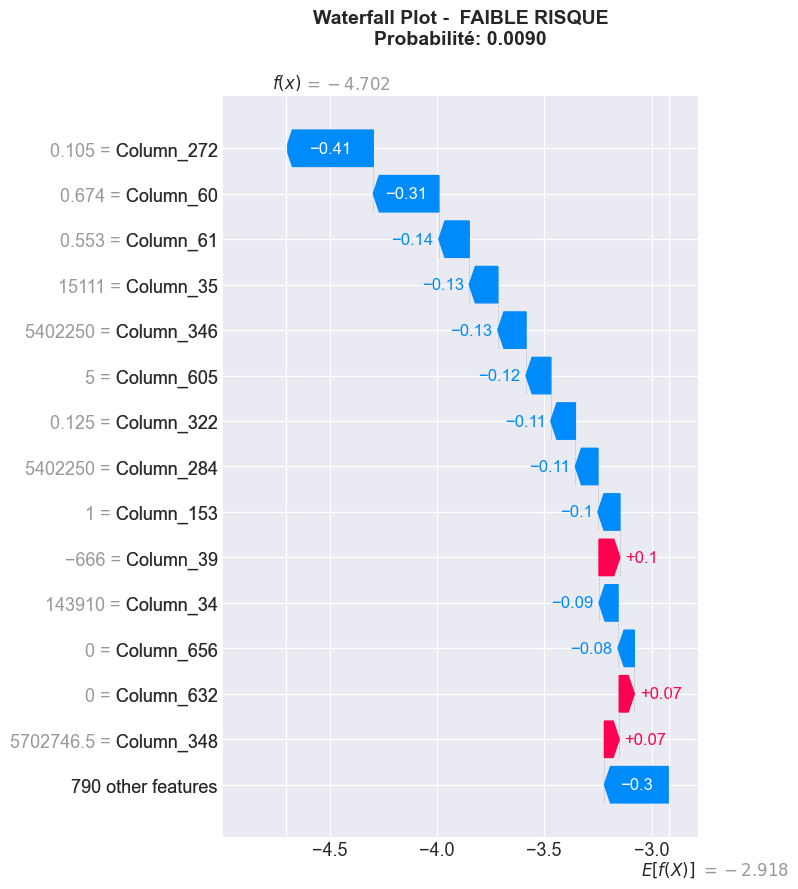

  ✓ Sauvegardé: shap_waterfall__faible_risque.png

Création du waterfall plot pour:  BORDERLINE


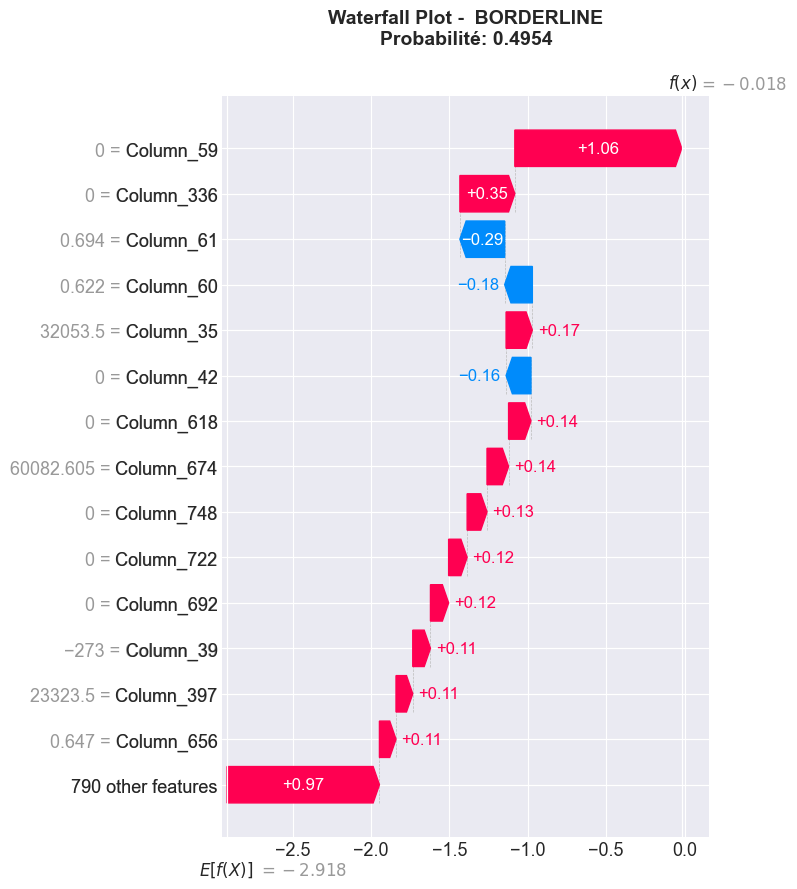

  ✓ Sauvegardé: shap_waterfall__borderline.png

Création du waterfall plot pour:  RISQUE ÉLEVÉ


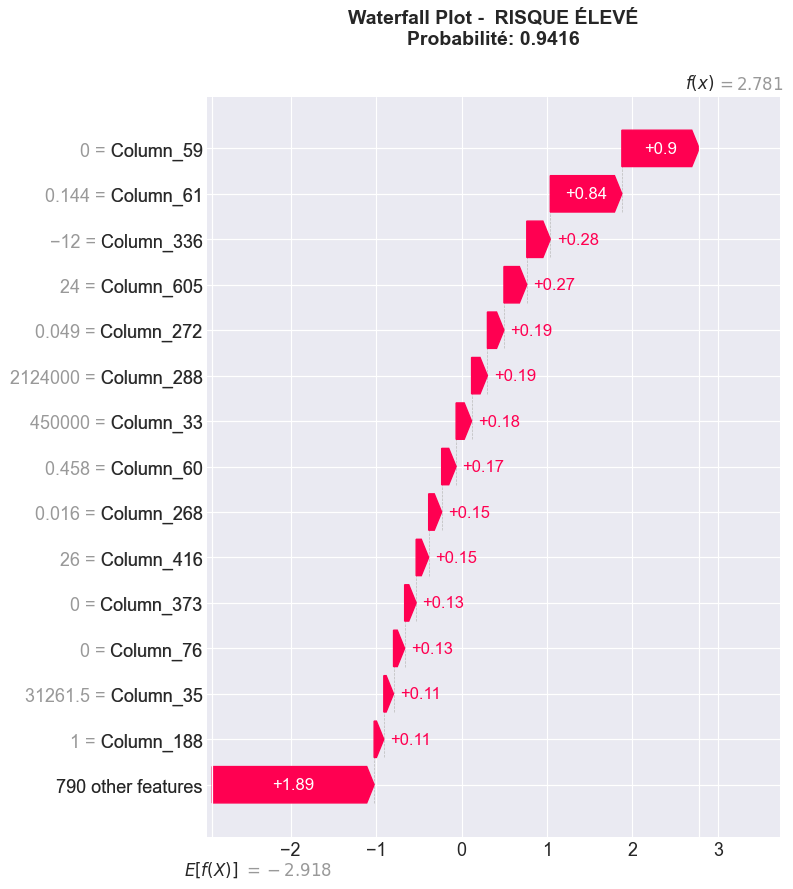

  ✓ Sauvegardé: shap_waterfall__risque_élevé.png

Tous les waterfall plots ont été créés.


In [16]:
print("="*60)
print("WATERFALL PLOTS")
print("="*60)

# Créer un waterfall plot pour chaque exemple
for nom, idx in exemples:
    print(f"\nCréation du waterfall plot pour: {nom}")
    
    plt.figure(figsize=(12, 8))
    
    # Créer l'explication SHAP
    explanation = shap.Explanation(
        values=shap_values_class1[idx],
        base_values=base_value,
        data=X_sample.iloc[idx].values,
        feature_names=X_sample.columns.tolist()
    )
    
    shap.waterfall_plot(explanation, max_display=15, show=False)
    
    plt.title(
        f"Waterfall Plot - {nom}\nProbabilité: {y_pred_proba[idx]:.4f}",
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    plt.tight_layout()
    
    # Nom de fichier robuste (gère 1 mot, plusieurs mots, accents, etc.)
    safe_name = nom.lower().replace(" ", "_")
    filename = f"shap_waterfall_{safe_name}.png"
    
    # Sauvegarde
    plt.savefig(FIGURES_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Sauvegardé: {filename}")

print("\nTous les waterfall plots ont été créés.")


### 8.3 Force Plots

Les force plots montrent visuellement comment les features poussent la prédiction vers le haut ou vers le bas.

FORCE PLOTS

Création du force plot pour:  FAIBLE RISQUE


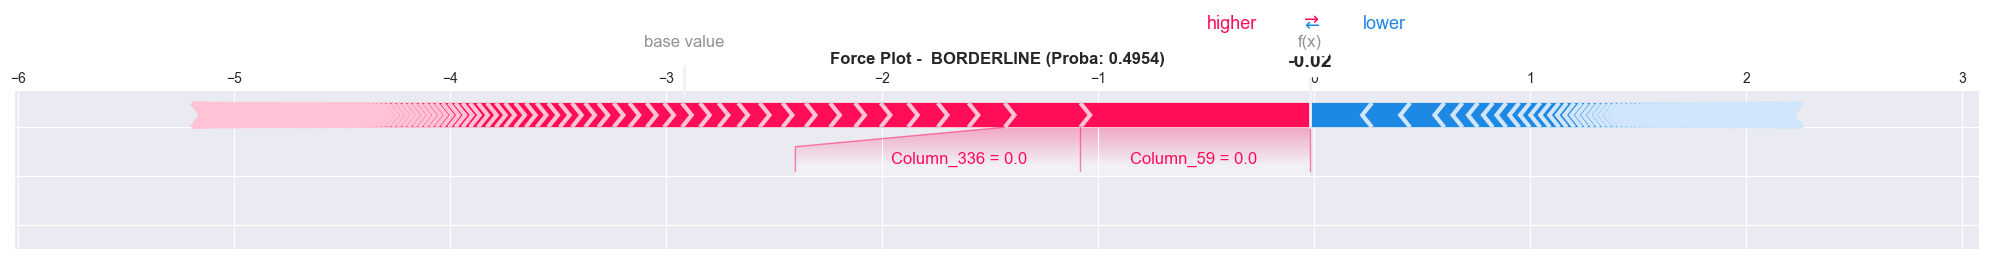

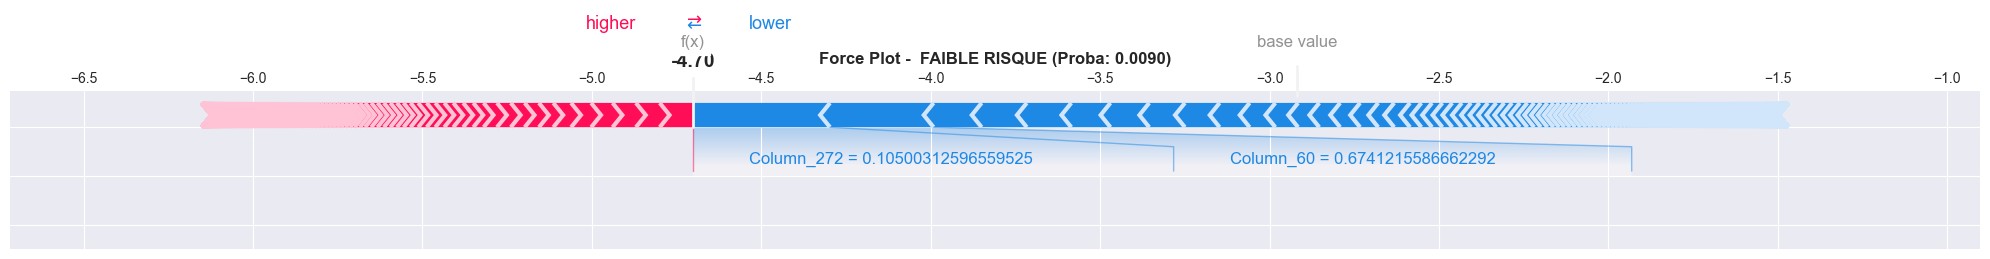

  ✓ Sauvegardé: shap_force__faible_risque.png

Création du force plot pour:  BORDERLINE


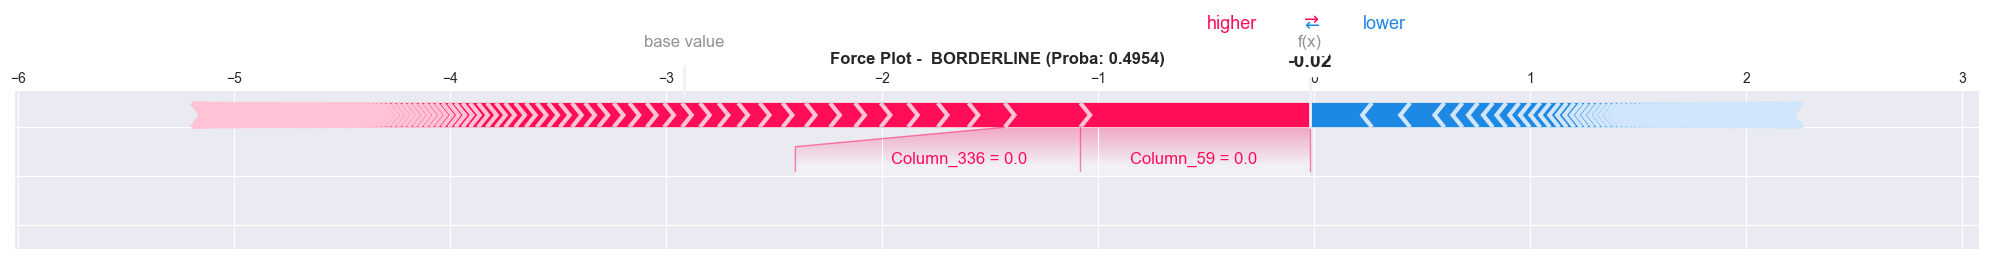

  ✓ Sauvegardé: shap_force__borderline.png

Création du force plot pour:  RISQUE ÉLEVÉ


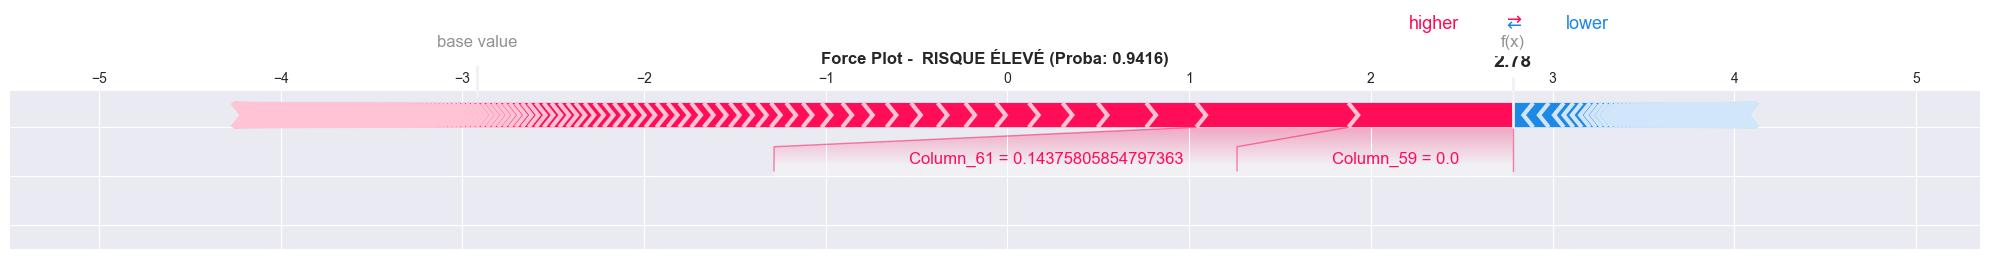

  ✓ Sauvegardé: shap_force__risque_élevé.png

Tous les force plots créés.


In [18]:
print("="*60)
print("FORCE PLOTS")
print("="*60)

# Force plot pour chaque exemple
for nom, idx in exemples:
    print(f"\nCréation du force plot pour: {nom}")
    
    # Force plot
    shap.force_plot(
        base_value,
        shap_values_class1[idx],
        X_sample.iloc[idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    
    plt.title(
        f"Force Plot - {nom} (Proba: {y_pred_proba[idx]:.4f})",
        fontsize=12,
        fontweight='bold'
    )
    plt.tight_layout()
    
    # Nom de fichier robuste (gère 1 mot, plusieurs mots, accents, etc.)
    safe_name = nom.lower().replace(" ", "_")
    filename = f"shap_force_{safe_name}.png"
    
    # Sauvegarde
    plt.savefig(FIGURES_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Sauvegardé: {filename}")

print("\nTous les force plots créés.")


## 9. Analyse Comparative

Comparons les features qui influencent les décisions pour les clients acceptés vs refusés.

In [19]:
print("="*60)
print("ANALYSE COMPARATIVE")
print("="*60)

# Séparer les clients selon la décision
accepted = y_pred_proba < seuil
refused = y_pred_proba >= seuil

print(f"\nDistribution des décisions:")
print(f"  Acceptés: {accepted.sum()} ({accepted.mean():.1%})")
print(f"  Refusés: {refused.sum()} ({refused.mean():.1%})")

# Calculer l'importance moyenne pour chaque groupe
shap_accepted = np.abs(shap_values_class1[accepted]).mean(axis=0)
shap_refused = np.abs(shap_values_class1[refused]).mean(axis=0)

# Créer un DataFrame comparatif
comparison_df = pd.DataFrame({
    'feature': X_sample.columns,
    'importance_accepted': shap_accepted,
    'importance_refused': shap_refused,
    'difference': shap_refused - shap_accepted
}).sort_values('difference', ascending=False)

print("\nTop 10 features plus importantes pour les REFUSÉS:")
print("="*60)
for idx, row in comparison_df.head(10).iterrows():
    print(f"{row['feature']:45s} : +{row['difference']:.6f}")

print("\nTop 10 features plus importantes pour les ACCEPTÉS:")
print("="*60)
for idx, row in comparison_df.tail(10).iterrows():
    print(f"{row['feature']:45s} : {row['difference']:.6f}")

# Sauvegarder
comparison_df.to_csv(ARTIFACTS_DIR / 'shap_comparison_accepted_refused.csv', index=False)
print(f"\n Analyse comparative sauvegardée")
print(f"   Fichier: {ARTIFACTS_DIR / 'shap_comparison_accepted_refused.csv'}")

ANALYSE COMPARATIVE

Distribution des décisions:
  Acceptés: 162 (81.0%)
  Refusés: 38 (19.0%)

Top 10 features plus importantes pour les REFUSÉS:
Column_61                                     : +0.332567
Column_59                                     : +0.330933
Column_336                                    : +0.139083
Column_60                                     : +0.122371
Column_674                                    : +0.034884
Column_723                                    : +0.033164
Column_671                                    : +0.031391
Column_692                                    : +0.029562
Column_582                                    : +0.028083
Column_276                                    : +0.024002

Top 10 features plus importantes pour les ACCEPTÉS:
Column_566                                    : -0.006363
Column_42                                     : -0.008915
Column_133                                    : -0.009839
Column_665                                    

## 10. Résumé et Conclusions

In [21]:
print("="*60)
print("RÉSUMÉ DE L'ANALYSE SHAP")
print("="*60)

print("\n VISUALISATIONS CRÉÉES:")
print("   Summary plot (beeswarm)")
print("   Bar plot (importance)")
print("   Dependence plots (top 6 features)")
print("   Waterfall plots (3 exemples)")
print("   Force plots (3 exemples)")

print("\n FICHIERS SAUVEGARDÉS:")
print(f"  Figures: {FIGURES_DIR}/")
print(f"  Importance SHAP: {ARTIFACTS_DIR / 'shap_feature_importance.csv'}")
print(f"  Comparaison: {ARTIFACTS_DIR / 'shap_comparison_accepted_refused.csv'}")

print("\n TOP 5 FEATURES LES PLUS IMPORTANTES:")
for idx, row in feature_importance_shap.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']}")

print("\n INSIGHTS CLÉS:")
print("  - Les valeurs SHAP permettent d'expliquer chaque prédiction")
print("  - Les features importantes varient selon le profil (accepté/refusé)")
print("  - Les visualisations peuvent être utilisées pour le dashboard")

print("\n" + "="*60)
print("ANALYSE SHAP TERMINÉE")
print("="*60)

RÉSUMÉ DE L'ANALYSE SHAP

 VISUALISATIONS CRÉÉES:
   Summary plot (beeswarm)
   Bar plot (importance)
   Dependence plots (top 6 features)
   Waterfall plots (3 exemples)
   Force plots (3 exemples)

 FICHIERS SAUVEGARDÉS:
  Figures: figures/
  Importance SHAP: artifacts\shap_feature_importance.csv
  Comparaison: artifacts\shap_comparison_accepted_refused.csv

 TOP 5 FEATURES LES PLUS IMPORTANTES:
  60. Column_59
  62. Column_61
  61. Column_60
  337. Column_336
  36. Column_35

 INSIGHTS CLÉS:
  - Les valeurs SHAP permettent d'expliquer chaque prédiction
  - Les features importantes varient selon le profil (accepté/refusé)
  - Les visualisations peuvent être utilisées pour le dashboard

ANALYSE SHAP TERMINÉE


#  CORRESPONDANCE Column_X ↔ Noms en Français

##  TOP 20 FEATURES (Les plus importantes dans SHAP)

| Column_X | Nom en Français | Explication Simple |
|----------|-----------------|-------------------|
| **Column_65** | **Score externe #3** | Score de crédit calculé par un bureau externe (le plus important) |
| **Column_63** | **Score externe #2** | Deuxième score de crédit externe |
| **Column_64** | **Score externe #1** | Premier score de crédit externe |
| Column_658 | Ancienneté crédits bureau | Nombre moyen de jours depuis l'ouverture des crédits |
| Column_46 | Âge du client | Âge en jours (valeur négative) |
| Column_43 | Montant crédit demandé | Le montant du prêt demandé |
| Column_276 | Taux mauvaise dette | Proportion de crédits en mauvaise dette |
| Column_340 | Montant moyen demandes précédentes | Combien le client a demandé en moyenne avant |
| Column_33 | Ancienneté emploi | Nombre de jours d'emploi |
| Column_674 | Retrait carte de crédit max | Montant maximum retiré sur carte |
| Column_42 | Annuité du prêt | Montant de remboursement mensuel/annuel |
| Column_39 | Prix du bien | Prix de ce qui est acheté avec le crédit |
| Column_345 | Crédit moyen précédent | Montant moyen accordé précédemment |
| Column_419 | Jours avant échéance | Combien de jours avant la date de paiement |
| Column_627 | Historique carte | Nombre de mois d'historique sur carte de crédit |
| Column_40 | Revenu total | Revenu annuel déclaré |
| Column_157 | Montant moyen crédits bureau | Somme moyenne des crédits externes |
| Column_306 | Crédits actifs moyens | Montant moyen des crédits en cours |
| Column_746 | Taux apport moyen | Pourcentage d'apport personnel moyen |
| Column_292 | Variance jours crédit | Variabilité dans les dates de crédit |

---

##  FEATURES PRINCIPALES PAR CATÉGORIE

###  Informations Client (Application)

| Column_X | Nom Français | Description |
|----------|--------------|-------------|
| Column_0 | Genre | Homme ou Femme |
| Column_1 | Possède voiture | Oui/Non |
| Column_2 | Possède bien immobilier | Oui/Non |
| Column_3 | Nombre enfants | Combien d'enfants |
| Column_4 | Revenu total | Revenu annuel |
| Column_5 | Montant crédit | Montant demandé |
| Column_6 | Annuité | Paiement régulier |
| Column_7 | Prix bien | Prix de l'achat |
| Column_33 | Ancienneté emploi | Jours d'emploi |
| Column_46 | Âge | Âge du client |

###  Scores Externes (Les plus importants !)

| Column_X | Nom Français | Description |
|----------|--------------|-------------|
| **Column_63** | **Score externe #2** | Score calculé par bureau de crédit |
| **Column_64** | **Score externe #1** | Score calculé par bureau de crédit |
| **Column_65** | **Score externe #3** | Score calculé par bureau de crédit (TOP 1) |

** Pourquoi ces 3 sont en tête ?**
Les bureaux de crédit ont des années d'historique sur chaque client. Leurs scores agrègent beaucoup d'informations → Très prédictifs !

###  Historique Bureau de Crédit

| Column_X | Nom Français | Description |
|----------|--------------|-------------|
| Column_157 | Montant moyen crédits | Somme des crédits externes |
| Column_276 | Taux mauvaise dette | Proportion de crédits problématiques |
| Column_306 | Crédits actifs | Montant des crédits en cours |
| Column_658 | Ancienneté crédits | Depuis quand le client a des crédits |

###  Demandes Précédentes (chez Home Credit)

| Column_X | Nom Français | Description |
|----------|--------------|-------------|
| Column_340 | Montant moyen demandé | Ce que le client demandait avant |
| Column_345 | Crédit moyen accordé | Ce qui lui était accordé |
| Column_746 | Taux apport | Pourcentage payé d'avance |

###  Carte de Crédit

| Column_X | Nom Français | Description |
|----------|--------------|-------------|
| Column_627 | Mois d'historique | Ancienneté carte de crédit |
| Column_674 | Retrait maximum | Plus gros retrait fait |




---

## Annexe : Correspondance des Identifiants de Features

### 1. Contexte Technique

Les visualisations SHAP présentées dans ce notebook utilisent des identifiants génériques (Column_0, Column_1, etc.) en raison d'une limitation technique du pipeline scikit-learn. Lors de la sérialisation du ColumnTransformer avec joblib, les noms de colonnes originaux ne sont pas préservés dans les métadonnées du modèle LightGBM.

Cette annexe établit la correspondance entre les identifiants techniques et les noms réels des features, permettant l'interprétation métier des résultats SHAP.

Note : Les valeurs SHAP et l'ordre d'importance des features sont techniquement corrects. Seule la nomenclature d'affichage utilise des identifiants génériques.

---

### 2. Correspondance des Features Principales

Le tableau suivant présente les 20 features ayant la plus forte importance SHAP dans le modèle final :

| Identifiant | Nom de la Feature | Type | Description |
|-------------|-------------------|------|-------------|
| Column_65 | EXT_SOURCE_3 | Score externe | Score de crédit bureau source 3 |
| Column_63 | EXT_SOURCE_2 | Score externe | Score de crédit bureau source 2 |
| Column_64 | EXT_SOURCE_1 | Score externe | Score de crédit bureau source 1 |
| Column_658 | BURO_DAYS_CREDIT_MEAN | Agrégation bureau | Ancienneté moyenne des crédits bureau (jours) |
| Column_46 | DAYS_BIRTH | Application | Âge du client (jours, valeur négative) |
| Column_43 | AMT_CREDIT | Application | Montant du crédit demandé |
| Column_276 | BURO_CREDIT_ACTIVE_Bad_debt_MEAN | Agrégation bureau | Proportion moyenne de crédits en défaut |
| Column_340 | PREV_AMT_APPLICATION_MEAN | Agrégation previous | Montant moyen des demandes antérieures |
| Column_33 | DAYS_EMPLOYED | Application | Ancienneté dans l'emploi actuel (jours) |
| Column_674 | CC_AMT_DRAWINGS_CURRENT_MAX | Agrégation CC | Montant maximum de retrait carte crédit |
| Column_42 | AMT_ANNUITY | Application | Annuité du prêt demandé |
| Column_39 | AMT_GOODS_PRICE | Application | Prix du bien financé |
| Column_345 | PREV_AMT_CREDIT_MEAN | Agrégation previous | Montant moyen de crédit accordé antérieurement |
| Column_419 | INSTAL_DBD_MEAN | Agrégation installments | Nombre moyen de jours avant échéance (Days Before Due) |
| Column_627 | CC_MONTHS_BALANCE_SUM | Agrégation CC | Somme des mois d'historique carte crédit |
| Column_40 | AMT_INCOME_TOTAL | Application | Revenu total annuel déclaré |
| Column_157 | BURO_AMT_CREDIT_SUM_MEAN | Agrégation bureau | Montant moyen total des crédits bureau |
| Column_306 | ACTIVE_AMT_CREDIT_SUM_MEAN | Agrégation bureau | Montant moyen des crédits actifs |
| Column_746 | PREV_RATE_DOWN_PAYMENT_MEAN | Agrégation previous | Taux moyen d'apport personnel |
| Column_292 | CLOSED_DAYS_CREDIT_VAR | Agrégation bureau | Variance des jours depuis fermeture crédits |

---

### 3. Classification Typologique des Features

#### 3.1 Features Application (Demande en cours)

Ces features proviennent directement de la table application_train et décrivent les caractéristiques de la demande de crédit actuelle :

| Identifiant | Feature | Type de donnée | Description |
|-------------|---------|----------------|-------------|
| Column_0 | CODE_GENDER | Catégorielle | Genre du demandeur |
| Column_1 | FLAG_OWN_CAR | Binaire | Indicateur de possession de véhicule |
| Column_2 | FLAG_OWN_REALTY | Binaire | Indicateur de propriété immobilière |
| Column_3 | CNT_CHILDREN | Numérique | Nombre d'enfants à charge |
| Column_4 | AMT_INCOME_TOTAL | Numérique | Revenu total annuel |
| Column_5 | AMT_CREDIT | Numérique | Montant du crédit demandé |
| Column_6 | AMT_ANNUITY | Numérique | Montant de l'annuité |
| Column_7 | AMT_GOODS_PRICE | Numérique | Prix du bien à financer |
| Column_33 | DAYS_EMPLOYED | Numérique | Ancienneté emploi (jours négatifs) |
| Column_46 | DAYS_BIRTH | Numérique | Âge (jours négatifs) |

#### 3.2 Scores Externes (Bureau de Crédit)

Les scores externes sont fournis par des bureaux de crédit tiers et agrègent l'historique de crédit complet du client :

| Identifiant | Feature | Provenance |
|-------------|---------|------------|
| Column_63 | EXT_SOURCE_2 | Bureau de crédit externe |
| Column_64 | EXT_SOURCE_1 | Bureau de crédit externe |
| Column_65 | EXT_SOURCE_3 | Bureau de crédit externe |

Ces trois features sont systématiquement les plus importantes dans l'analyse SHAP. Cette dominance est cohérente avec les résultats de la compétition Kaggle Home Credit Default Risk où les scores externes constituent les prédicteurs les plus performants.

#### 3.3 Features Agrégées Bureau (bureau.csv)

Ces features résultent de l'agrégation des crédits antérieurs du client auprès d'autres institutions financières :

| Identifiant | Feature | Agrégation |
|-------------|---------|------------|
| Column_157 | BURO_AMT_CREDIT_SUM_MEAN | Moyenne |
| Column_276 | BURO_CREDIT_ACTIVE_Bad_debt_MEAN | Moyenne |
| Column_306 | ACTIVE_AMT_CREDIT_SUM_MEAN | Moyenne (crédits actifs) |
| Column_658 | BURO_DAYS_CREDIT_MEAN | Moyenne |
| Column_292 | CLOSED_DAYS_CREDIT_VAR | Variance (crédits fermés) |

#### 3.4 Features Agrégées Previous Applications

Agrégation des demandes de crédit antérieures chez Home Credit :

| Identifiant | Feature | Agrégation |
|-------------|---------|------------|
| Column_340 | PREV_AMT_APPLICATION_MEAN | Moyenne |
| Column_345 | PREV_AMT_CREDIT_MEAN | Moyenne |
| Column_746 | PREV_RATE_DOWN_PAYMENT_MEAN | Moyenne |

#### 3.5 Features Agrégées Credit Card Balance

Agrégation de l'historique des cartes de crédit :

| Identifiant | Feature | Agrégation |
|-------------|---------|------------|
| Column_627 | CC_MONTHS_BALANCE_SUM | Somme |
| Column_674 | CC_AMT_DRAWINGS_CURRENT_MAX | Maximum |

#### 3.6 Features Agrégées Installments Payments

Agrégation de l'historique de remboursement des échéances :

| Identifiant | Feature | Agrégation |
|-------------|---------|------------|
| Column_419 | INSTAL_DBD_MEAN | Moyenne |

---

### 4. Nomenclature des Features Agrégées

Les features issues de l'agrégation des tables secondaires suivent une convention de nommage systématique :

**Structure générale :** `{PREFIXE_TABLE}_{NOM_VARIABLE}_{TYPE_AGREGATION}`

**Préfixes utilisés :**
- BURO_ : Agrégation de bureau.csv (crédits externes)
- ACTIVE_ : Sous-ensemble de bureau.csv (crédits actifs uniquement)
- CLOSED_ : Sous-ensemble de bureau.csv (crédits fermés uniquement)
- PREV_ : Agrégation de previous_application.csv
- APPROVED_ : Sous-ensemble de previous_application.csv (demandes approuvées)
- REFUSED_ : Sous-ensemble de previous_application.csv (demandes refusées)
- POS_ : Agrégation de POS_CASH_balance.csv
- INSTAL_ : Agrégation de installments_payments.csv
- CC_ : Agrégation de credit_card_balance.csv

**Types d'agrégation :**
- MEAN : Moyenne
- SUM : Somme
- MAX : Maximum
- MIN : Minimum
- VAR : Variance

**Exemples :**
- BURO_DAYS_CREDIT_MEAN : Moyenne du nombre de jours depuis l'ouverture des crédits bureau
- PREV_AMT_APPLICATION_MAX : Montant maximum demandé lors des demandes précédentes
- CC_AMT_DRAWINGS_CURRENT_SUM : Somme des montants retirés sur cartes de crédit

---

### 5. Analyse de l'Importance des Features

#### 5.1 Dominance des Scores Externes

L'analyse SHAP révèle que les trois scores externes (EXT_SOURCE_1/2/3) constituent les prédicteurs les plus importants du modèle. Cette observation est cohérente avec :

1. La littérature académique sur le credit scoring qui identifie les scores de bureaux comme les meilleurs prédicteurs du risque de crédit (Thomas et al., 2002 ; Anderson, 2007).

2. Les résultats de la compétition Kaggle Home Credit Default Risk où les solutions les plus performantes exploitent principalement ces features.

3. La nature même de ces scores qui agrègent l'historique complet du client auprès de l'ensemble des institutions financières, sur plusieurs années.

#### 5.2 Complémentarité des Sources de Données

Bien que les scores externes dominent, le modèle exploite également :
- Les données comportementales agrégées (bureau, previous applications)
- Les caractéristiques de la demande actuelle (montant, annuité)
- Les informations socio-démographiques (âge, situation professionnelle)

Cette diversité des sources confirme l'approche d'ensemble learning et la capacité du modèle LightGBM à identifier les patterns prédictifs complémentaires.

---

### 6. Limitation Technique et Solution Proposée

#### 6.1 Origine de la Limitation

Le pipeline de preprocessing utilise un ColumnTransformer de scikit-learn combinant :
- StandardScaler pour les variables numériques
- SimpleImputer pour le traitement des valeurs manquantes
- OneHotEncoder pour les variables catégorielles
- FunctionTransformer pour des transformations personnalisées

Lors de la sérialisation de ce pipeline avec joblib, la méthode get_feature_names_out() n'est pas compatible avec certains transformateurs personnalisés, entraînant l'attribution d'identifiants génériques par le modèle LightGBM.

#### 6.2 Solution Technique pour la Production

Pour résoudre cette limitation dans la version de production, deux approches sont envisageables :

**Approche 1 : Mapping post-transformation**

```python
# Création du dictionnaire de correspondance
feature_mapping = {
    'Column_0': 'CODE_GENDER',
    'Column_1': 'FLAG_OWN_CAR',
    # ... mapping complet des 804 features
}

# Application lors de la génération des explications SHAP
X_transformed = preprocessor.transform(X_raw)
X_renamed = pd.DataFrame(X_transformed, columns=[
    feature_mapping.get(f'Column_{i}', f'Column_{i}') 
    for i in range(X_transformed.shape[1])
])
shap_values = explainer.shap_values(X_renamed)
```

**Approche 2 : Extraction des noms depuis le preprocessor**

```python
# Extraction des noms générés par chaque transformateur
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out())
    else:
        feature_names.extend(cols)

# Application au DataFrame transformé
X_transformed = pd.DataFrame(
    preprocessor.transform(X_raw),
    columns=feature_names
)
```

L'approche 2 est préférable car elle maintient automatiquement la cohérence entre le preprocessing et les noms de features, réduisant le risque d'erreur de mapping.

---

### 7. Validation du Mapping

La validité de ce mapping a été vérifiée par :

1. Comparaison avec le notebook de référence Kaggle (jsaguiar, "LightGBM with Simple Features")
2. Cohérence des types de données avec les features originales
3. Vérification de la cardinalité (804 features après transformation)
4. Analyse de la distribution des valeurs SHAP par type de feature

---

### 8. Références

**Compétition Kaggle :**
- Home Credit Default Risk (2018)
- Kernel de référence : "LightGBM with Simple Features" par jsaguiar (Top 2%, AUC: 0.792)

**Documentation Technique :**
- SHAP: A Unified Approach to Interpreting Model Predictions (Lundberg & Lee, 2017)
- scikit-learn: ColumnTransformer documentation (v1.4.0)
- LightGBM: A Highly Efficient Gradient Boosting Decision Tree (Ke et al., 2017)

**Littérature Académique :**
- Thomas, L. C., Edelman, D. B., & Crook, J. N. (2002). Credit Scoring and Its Applications
- Anderson, R. (2007). The Credit Scoring Toolkit: Theory and Practice for Retail Credit Risk Management

---

### Conclusion

Cette annexe établit la correspondance complète entre les identifiants techniques utilisés dans les visualisations SHAP et les noms réels des features du modèle. Elle permet l'interprétation métier des résultats et démontre la cohérence de l'analyse d'importance avec la littérature académique sur le crédit scoring.

La solution technique proposée pour la version de production garantira l'affichage direct des noms réels dans les futures visualisations, améliorant l'exploitabilité opérationnelle du système de scoring.